In [1]:
# load required packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx
import networkx as nx
import pandas as pd
import re
import random
from ndex2.cx2 import CX2Network

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

#from gprofiler import GProfiler
#gp = GProfiler("MyToolName/0.1")

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

from datetime import datetime
import sys
%matplotlib inline
import networkx

In [2]:
# verify DDOT was installed
import ddot

from netcoloc import netprop_zscore, netprop, network_colocalization, validation


/tscc/nfs/home/hiyoothere/miniconda3/envs/r4/lib/python3.12/site-packages/netcoloc/validation.py:20: UserWarning: Import of ddot failed. NetColoc will not work properly: + cannot import name 'Ontology' from 'ddot' (/tscc/nfs/home/hiyoothere/miniconda3/envs/r4/lib/python3.12/site-packages/ddot/__init__.py)
  warnings.warn('Import of ddot failed. NetColoc will not work properly: + ' + str(ie))


## 2. Select two gene sets of interest. Load gene sets from text files into python.

In [3]:
d1_name='MM DNM gens'

In [4]:
#Get alias gene 
f_alias = open("/tscc/projects/ps-gleesonlab7/gleeson3/resources/HGNC/Gene_SYNONYM.txt", 'r')
dic_alias = {} #alias:general

for line in f_alias:
    if "Approved" not in line:
        s = line.strip().split("\t")
        #print (len(s))
        approved = s[0]
        if len(s) ==2:
            if ',' in s[1]:
                l_alias = s[1].split(',')
                for i in l_alias:
                    dic_alias[i.strip()] = approved
            else:
                dic_alias[s[1]] = approved
        elif len(s) == 3:
            if ',' in s[1]:
                l_alias = s[1].split(',')
                for i in l_alias:
                    
                    dic_alias[i.strip()] = approved
            else:
                dic_alias[s[1]] = approved
            if ',' in s[2]:
                l_previous = s[2].split(',')

                for i in l_previous:
                    dic_alias[i.strip()] = approved
            else:
                dic_alias[s[2]] = approved


In [5]:
# ------ customize this section based your input genesets -------

D1_df = pd.read_csv('/tscc/projects/ps-gleesonlab8/User/hiyoothere/NTD/5.Analysis/DNM/Burden/NTD_DamMC2_woINVALID.den_input',sep='\t')
D1_genes = D1_df['SYMBOL'].tolist()
#Remove duplicates
D1_genes = list(set(D1_genes))

        
print('Number of '+d1_name+' genes:',len(D1_genes))
print('First 5 genes:', D1_genes[0:5])

Number of MM DNM gens genes: 187
First 5 genes: ['GRIA3', 'SLC30A6', 'RXFP2', 'FAM83G', 'ZSWIM6']


## 3. Select gene interaction network to use for the analysis.

In [6]:
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# remove self edges from network
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out the numbers of nodes and edges in the interatome for diagnostic purposes:
print('Number of nodes:', len(G_int.nodes))
print('\nNumber of edges:', len(G_int.edges))

Number of nodes: 18820

Number of edges: 2693109


In [7]:
int_nodes = list(G_int.nodes)

# Identify network colocalized gene network

## 4. Precalculate matrices needed for propagation. This step should take a few minutes (more for larger/denser networks)

In [8]:
# pre-calculate matrices used for network propagation. this step takes a few minutes, more for denser interactomes
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(G_int, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)




calculating w_prime

calculating w_double_prime


## 5. Subset seed genes to those found in the selected network.

In [9]:
for MM in D1_genes:
    if MM not in int_nodes:
        print (MM)

LAMA3
H3-4
SLCO1B3-SLCO1B7
MGA
MAP2
POP1


In [10]:
# subset seed genes to those found in interactome
print("Number of D1 genes:", len(D1_genes))


D1_new = []
for MM in D1_genes:
    if MM in int_nodes:
        D1_new.append(MM)
    if MM not in int_nodes:
        if MM in dic_alias:
            #print (MM, dic_alias[MM])
            D1_new.append(MM)
        else:
            print ("Not present", MM)
        
D1_genes = D1_new
print("Number of D1 genes in interactome:", len(D1_genes))

Number of D1 genes: 187
Not present H3-4
Not present SLCO1B3-SLCO1B7
Number of D1 genes in interactome: 185


##  6. Compute network proximity scores from seed gene set.


In [11]:
# D1 network propagation
print('\nCalculating D1 z-scores: ')
z_D1, Fnew_D1, Fnew_rand_D1 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    D1_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_D1 = pd.DataFrame({'z':z_D1})

z_D1.sort_values('z',ascending=False).head()


Calculating D1 z-scores: 


  0%|          | 0/1000 [00:00<?, ?it/s]

,z
CLTC,21.341222
HNRNPL,19.767824
VDAC2,19.187881
CNPY1,19.097940
FAM83G,17.947948


## 7. Build proximal subnetwork by taking z> thresh

In [12]:

# ----------- select thresholds for NetColoc -----------------
zthresh=3 # default = 3

# select the genes in the network intersection, make a subgraph

G_prox = nx.subgraph(G_int,z_D1[z_D1['z']>zthresh].index.tolist()) 
print("Nodes in proximal subgraph:", len(G_prox.nodes()))
print("Edges in proximal subgraph:", len(G_prox.edges()))




# compile dataframe of metadata for overlapping nodes
node_df = pd.DataFrame(index=list(G_prox.nodes))
node_df = node_df.assign(d1_seeds=0, d1_name=d1_name)
node_df.head()
node_df.loc[list(np.intersect1d(node_df['d1_seeds'].keys() ,D1_genes)), 'd1_seeds']=1
node_df['z_d1']=z_D1.loc[list(G_prox.nodes)]['z']
#node_df['z_d2']=z_D2.loc[list(G_overlap.nodes)]['z']
#node_df['z_both']=node_df['z_d1']*node_df['z_d2']
#node_df['sum_seeds']=node_df['d1_seeds']+node_df['d2_seeds']

node_df = node_df.sort_values('z_d1',ascending=False)
print (node_df.head(15))



Nodes in proximal subgraph: 439
Edges in proximal subgraph: 2447
          d1_seeds      d1_name       z_d1
CLTC             1  MM DNM gens  21.341222
HNRNPL           1  MM DNM gens  19.767824
VDAC2            1  MM DNM gens  19.187881
CNPY1            1  MM DNM gens  19.097940
FAM83G           1  MM DNM gens  17.947948
GTF3C3           1  MM DNM gens  17.852848
MFAP1            1  MM DNM gens  17.846594
DPYSL2           1  MM DNM gens  17.695655
LEMD3            1  MM DNM gens  16.780574
TOP2B            1  MM DNM gens  16.752226
C6orf132         1  MM DNM gens  16.370847
CRHR2            1  MM DNM gens  16.271097
SMURF2           1  MM DNM gens  16.069396
ATAD3B           1  MM DNM gens  15.869375
SPEN             1  MM DNM gens  15.622895


# ** Hypergeometric test

In [13]:
#1. Mouse gene and the DNM gene
MO_df = pd.read_csv('/tscc/projects/ps-gleesonlab8/User/hiyoothere/NTD/12.Network_propagation/MouseNTDgene/raw_221017.f.HumanConv.txt',sep='\t', encoding = "cp1252")
MO_genes = MO_df['gene'].tolist()
print('Number of Mouse NTD genes:',len(MO_genes))
print('First 5 genes:', MO_genes[0:5])

print('Number of DNM NTD genes:',len(D1_genes))
print('First 5 genes:', D1_genes[0:5], '\n\n')


overlap_DNM = np.intersect1d(D1_genes,MO_genes)
print('Number of overalps of DNM NTD genes and Mouse NTD genes:',len(overlap_DNM), '\n')
print('THOSE genes::', overlap_DNM)
cnt_overlap_DNM = len(overlap_DNM)
print ("\n\n\n")

#2. Mouse gene and propagated genes

Prop_genes = node_df['d1_seeds'].keys()
print('Number of Prop_genes:',len(Prop_genes))
print('First 5 genes:', Prop_genes[0:5])



overlap_prop = np.intersect1d(MO_genes,Prop_genes)
print('Number of overalps of Prop genes genes and Mouse NTD genes:',len(overlap_prop), '\n')
print('THOSE genes::', overlap_prop)
cnt_overlap_prop = len(overlap_prop)
print ("\n\n\n")




Number of Mouse NTD genes: 374
First 5 genes: ['EFNA5', 'EPHA7', 'FREM1', 'FREM2', 'GJA1']
Number of DNM NTD genes: 185
First 5 genes: ['GRIA3', 'SLC30A6', 'RXFP2', 'FAM83G', 'ZSWIM6'] 


Number of overalps of DNM NTD genes and Mouse NTD genes: 11 

THOSE genes:: ['CELSR1' 'EP300' 'FREM1' 'GRHL2' 'GRHL3' 'MIB2' 'PAX3' 'SCRIB' 'SMURF2'
 'TBXT' 'TIAM1']




Number of Prop_genes: 439
First 5 genes: Index(['CLTC', 'HNRNPL', 'VDAC2', 'CNPY1', 'FAM83G'], dtype='object')
Number of overalps of Prop genes genes and Mouse NTD genes: 17 

THOSE genes:: ['BMP7' 'CELSR1' 'DYNC2H1' 'EP300' 'FREM1' 'FREM2' 'GRHL2' 'GRHL3' 'MIB2'
 'PAX3' 'SCRIB' 'SLC25A19' 'SMURF2' 'SS18' 'TBXT' 'TIAM1' 'TULP3']






In [14]:
from scipy.stats import hypergeom
import matplotlib.pyplot as plt

In [15]:
[M, n, N] = [18820, len(MO_genes), len(G_prox.nodes())]
#https://www.science.org/doi/10.1126/science.abj6987
#M = KNOWN NTD GENE ( MOUSE GENE)
#N = CNT_PROP_GENE
rv = hypergeom(M, n, N)
#rv = hypergeom(20, 7, 12)
x = np.arange(0, n+1)
pmf = rv.pmf(x)
pmf

array([1.34076912e-004, 1.22243180e-003, 5.54482682e-003, 1.66831247e-002,
       3.74576026e-002, 6.69420512e-002, 9.91922661e-002, 1.25344513e-001,
       1.37889401e-001, 1.34149284e-001, 1.16860355e-001, 9.20717947e-002,
       6.61553653e-002, 4.36519228e-002, 2.66080628e-002, 1.50594962e-002,
       7.94920474e-003, 3.92868290e-003, 1.82423114e-003, 7.98286880e-004,
       3.30128623e-004, 1.29340228e-004, 4.81160856e-005, 1.70312077e-005,
       5.74665119e-006, 1.85159957e-006, 5.70599659e-007, 1.68424387e-007,
       4.76823320e-008, 1.29639451e-008, 3.38886739e-009, 8.52680339e-010,
       2.06717905e-010, 4.83334880e-011, 1.09091026e-011, 2.37886745e-012,
       5.01579822e-013, 1.02335723e-013, 2.02182114e-014, 3.87062255e-015,
       7.18489806e-016, 1.29397842e-016, 2.26230890e-017, 3.84180072e-018,
       6.34021624e-019, 1.01736611e-019, 1.58804269e-020, 2.41244417e-021,
       3.56822606e-022, 5.14078087e-023, 7.21707897e-024, 9.87679965e-025,
       1.31811545e-025, 1

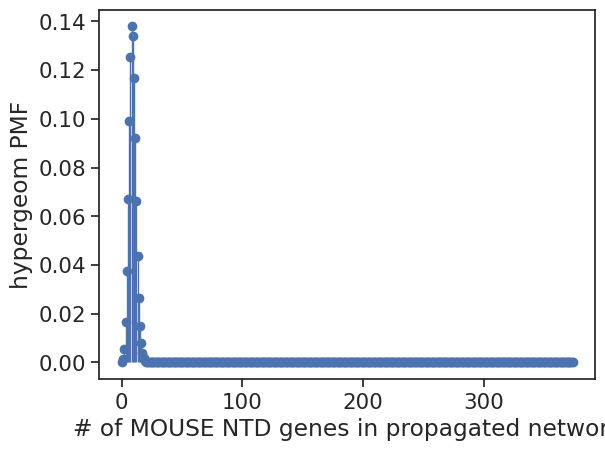

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, pmf, 'bo')
ax.vlines(x, 0, pmf, lw=1)
ax.set_xlabel('# of MOUSE NTD genes in propagated network')
ax.set_ylabel('hypergeom PMF')
plt.show()

In [17]:
prb = hypergeom.cdf(len(overlap_prop), M, n, N) 
prb
(1-prb)/2

0.0015777682995173348

In [23]:
G_prox_cx = ndex2.create_nice_cx_from_networkx(G_prox)
network_uuid_hier = G_prox_cx.upload_to('ndexbio.org', 'jiny', '')

Generating CX
